In [232]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [241]:
class mixdensnet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_mixtures):
        super().__init__()
        
        self.hidden_block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.pi = nn.Linear(hidden_dim, n_mixtures)
        self.mu = nn.Linear(hidden_dim, n_mixtures)
        self.sigma = nn.Linear(hidden_dim, n_mixtures)
        
    def forward(self, x):
        # x = self.block(x)
        hidden = self.hidden_block(x)
        # Separate the output into mixture components
        pi, mu, sigma = F.softmax(self.pi(hidden), 1), self.mu(hidden), torch.exp(self.sigma(hidden))
        
        return pi, mu, sigma

In [242]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

#Generate some example data
n_samples = 1000
epsilon = torch.randn(n_samples)
x_train = torch.linspace(-10, 10, n_samples)
y_train = 5*np.sin(0.75*x_train) + 0.3*x_train + epsilon

y_train, x_train = x_train.view(-1, 1), y_train.view(-1, 1)

x_train = torch.linspace(-10, 10, 1000).unsqueeze(1).cpu().numpy()
y_train = (7*np.sin(0.75*x_train) + 0.5*x_train + np.random.normal())

# Convert the data to PyTorch tensors
x_train, y_train = torch.from_numpy(x_train).to(device), torch.from_numpy(y_train).to(device)

# Define the MDN
mdn = mixdensnet(input_dim=1, hidden_dim=30, n_mixtures=5).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(params=mdn.parameters(), 
                             lr=0.001)

# Define the loss function
def mdn_loss(y, mu, sigma, pi):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=1)
    loss = -torch.log(loss)
    return torch.mean(loss)

In [243]:
for epoch in range(5000):
    ### Training
    mdn.train()

    # 1. Forward pass
    pi, mu, sigma = mdn(x_train)
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = mdn_loss(y_train, mu, sigma, pi)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    mdn.eval()
    with torch.inference_mode():
      # 1. Forward pass
      pi, mu, sigma = mdn(x_train)
      
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}")

Epoch: 0 | Loss: 10.67237
Epoch: 10 | Loss: 6.81358
Epoch: 20 | Loss: 5.18630
Epoch: 30 | Loss: 4.38184
Epoch: 40 | Loss: 4.05243
Epoch: 50 | Loss: 3.82988
Epoch: 60 | Loss: 3.68035
Epoch: 70 | Loss: 3.58077
Epoch: 80 | Loss: 3.50119
Epoch: 90 | Loss: 3.42961
Epoch: 100 | Loss: 3.36510
Epoch: 110 | Loss: 3.31558
Epoch: 120 | Loss: 3.27784
Epoch: 130 | Loss: 3.24402
Epoch: 140 | Loss: 3.21096
Epoch: 150 | Loss: 3.17572
Epoch: 160 | Loss: 3.13458
Epoch: 170 | Loss: 3.08783
Epoch: 180 | Loss: 3.04865
Epoch: 190 | Loss: 3.02377
Epoch: 200 | Loss: 3.00289
Epoch: 210 | Loss: 2.98393
Epoch: 220 | Loss: 2.96541
Epoch: 230 | Loss: 2.94695
Epoch: 240 | Loss: 2.92860
Epoch: 250 | Loss: 2.91116
Epoch: 260 | Loss: 2.89506
Epoch: 270 | Loss: 2.87772
Epoch: 280 | Loss: 2.86213
Epoch: 290 | Loss: 2.84643
Epoch: 300 | Loss: 2.82980
Epoch: 310 | Loss: 2.81186
Epoch: 320 | Loss: 2.79123
Epoch: 330 | Loss: 2.76822
Epoch: 340 | Loss: 2.74402
Epoch: 350 | Loss: 2.71935
Epoch: 360 | Loss: 2.69461
Epoch: 370 

In [244]:
k = torch.multinomial(pi, 1).view(-1)
y_pred = torch.normal(mu, sigma)[np.arange(len(x_train)), k].data

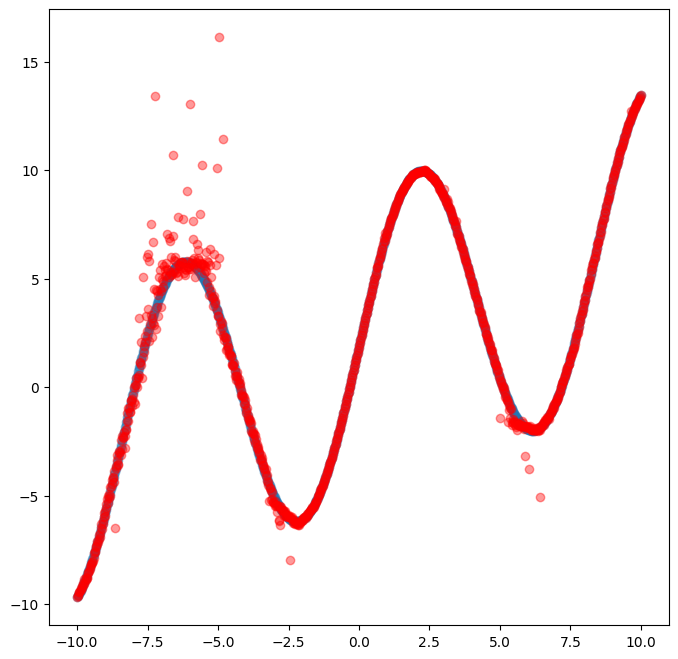

In [245]:
plt.figure(figsize=(8, 8))
plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), alpha=0.4, label="Real values")
plt.scatter(x_train.cpu().numpy(), y_pred.cpu().numpy(), alpha=0.4, color='red', label="In-sample prediction")
plt.show()

In [246]:
# Generate predictions from the trained MDN
x_test = torch.linspace(-5, 5, 100).unsqueeze(1).to(device)
pi, mu, sigma = mdn(x_test)
y_pred = torch.sum(pi * mu, dim=1)

In [247]:
y_pred

tensor([ 3.7644,  3.2153,  2.6862,  2.1774,  1.6864,  1.2094,  0.7432,  0.2849,
        -0.1679, -0.6171, -1.0644, -1.5113, -1.9596, -2.4108, -2.8669, -3.3289,
        -3.7953, -4.2588, -4.7012, -5.0922, -5.4025, -5.6393, -5.7905, -5.8925,
        -5.9775, -6.0635, -6.1527, -6.2437, -6.3412, -6.2195, -6.0683, -5.9205,
        -5.7642, -5.6069, -5.3825, -5.0706, -4.7588, -4.4302, -4.0476, -3.6395,
        -3.2300, -2.7482, -2.2561, -1.7533, -1.2288, -0.6846, -0.1262,  0.4320,
         1.0086,  1.5878,  2.1668,  2.7484,  3.3215,  3.8931,  4.4484,  5.0077,
         5.5364,  6.0411,  6.5375,  6.9762,  7.4165,  7.8258,  8.1821,  8.5290,
         8.8513,  9.1105,  9.3538,  9.5429,  9.7321,  9.8262,  9.9017,  9.9347,
         9.9675,  9.9457,  9.8157,  9.6862,  9.5575,  9.4033,  9.1372,  8.8765,
         8.6158,  8.3328,  7.9936,  7.5913,  7.1560,  6.7145,  6.2761,  5.8138,
         5.3426,  4.8716,  4.3998,  3.9264,  3.4501,  2.9699,  2.4844,  1.9919,
         1.5254,  1.0803,  0.6297,  0.17